In [1]:
# Basic libraries
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import math
import time
import itertools

# Network libraries
import networkx as nx
from fa2 import ForceAtlas2 as FA2
import community

# NLP libraries
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.probability import FreqDist
from wordcloud import WordCloud, ImageColorGenerator

# Display libraries
from IPython.display import display
from IPython.core.display import display as disp, HTML
from ipywidgets import widgets, interact, interactive, fixed, interact_manual
from IPython.display import Image
import imageio

from plotly import __version__
import plotly.io as pio
import plotly.express as px
import plotly.figure_factory as ff
import chart_studio.plotly as py
import plotly.offline
import plotly.graph_objs as go
sns.set()

pio.renderers.default = 'notebook'

business_df = pd.read_csv('./data/las_vegas_all_business.csv')
review_df = pd.read_csv('./data/las_vegas_all_reviews.csv')
keywords = pd.read_csv('./data/las_vegas_business_keywords.csv')

import warnings
warnings.filterwarnings('ignore')
# Filter business_id according to the category
filter_business_id = business_df[business_df.categories.str.contains(r"(Hotels, )|(, Hotels$)", regex = True)==True].business_id
# Filter businesses
business_df = business_df[business_df.business_id.isin(filter_business_id)].reset_index().drop('index', axis = 1).rename({'stars': 'stars_business'})
# Filter reviews based on business_id
review_df = review_df[review_df.business_id.isin(filter_business_id)].reset_index().drop('index', axis = 1).rename({'stars': 'stars_review'})

In [2]:
business_review_df = pd.merge(business_df, review_df, on='business_id', how='outer')
# Function to test if something is an adjective
is_adj = (lambda pos: pos[:2] == 'JJ')

# Function for tokenizing the text into a list of words
def tokenize_text(text):
    # Replace all the non-alphanumeric characters with space
    text = re.sub(r'[\W]', ' ', text)

    # Tokenize texts into lists of tokens
    words = word_tokenize(text)    
   
    stop_words = set(stopwords.words('english'))
       
    words = [word.lower() for word in words if word not in string.punctuation]    # Remove punctuation and set words to lowercase
    words = [word for word in words
                 if word not in stop_words
                 if len(word) > 1]    # Remove stopwords and letters (stopwords are lowercase, so this step should be done after word.lower())
    words = [word for (word, pos) in nltk.pos_tag(words) if is_adj(pos)]    # Keep adjectives only

    return words

def reviews(df, mode, dict_communities = None):
    
    if mode == 'community':
        # Create a dictionary for storing text of each community
        community_reviews = {}
        for comm in dict_communities.keys():
            community_text = ' '
            for business_id in dict_communities[comm]:
                business_text = ' '.join(df[df.business_id==business_id].text)
                community_text += business_text
            community_reviews[comm] = community_text
        return community_reviews
      
    if mode == 'business':
        # Within each business
        business_reviews = {}
        for business_id in df.business_id.unique():      
            # Concatenate all reviews of a specific business into one text
            business_text = ' '.join(df[df.business_id==business_id].text)
            business_reviews[business_id]  = business_text
        return business_reviews
    
# Function for computing TF (using different methods)
def tf(reviews, tf_method = 'term_frequency'):

    # Create a nested dictionary {business: {word: tf score}} or {business: {word: tf score}} for storing term-frequency
    term_frequency = {}

    for comm, review in reviews.items():
        # Create a dictionary for each either community or business to store words and counts of words
        term_frequency[comm] = {}

        # Total word amount for one business (for tf_method=='term_frequency')
        total_word_amount = len(review)
        # Tokenize the text into a list of words
        words = tokenize_text(review)
        # Count words
        for word in words:
            if word not in term_frequency[comm].keys():
                term_frequency[comm][word] = 1
            else:
                term_frequency[comm][word] += 1       

        # Compute different types of term frequency
        if tf_method == 'raw_count':
            term_frequency = term_frequency

        elif tf_method == 'term_frequency':
            term_frequency[comm] = {k : v/total_word_amount for k, v in term_frequency[comm].items()}

        elif tf_method == 'log':
            term_frequency[comm] = {k : math.log(1 + v) for k, v in term_frequency[comm].items()}

        elif tf_method == 'double_normalization':
            term_frequency[comm] = {k : (0.5 + 0.5*v/max(term_frequency[comm].values())) for k, v in term_frequency[comm].items()}        

    return term_frequency

# Function for computing IDF (using different methods)
def idf(reviews, term_frequency, idf_method='idf'):
    # Total number of documents (i.e. total number of businesses in this case, because we concatenate all the reviews of one specific business)
    N = len(reviews.keys())
    
    # Create a nested dictionary for {business: {word: idf score}} storing term-frequency
    inverse_document_frequency = {}
    
    for comm1 in term_frequency.keys():
        # Update the idf dictionary into form as {business: {word: 0}}
        inverse_document_frequency[comm1] = {k : 0 for k in term_frequency[comm1].keys()}
        
        for word in term_frequency[comm1]:
            # If a specific word occurs in another business, add 1 to the count of this word
            for comm2 in term_frequency.keys():
                if word in term_frequency[comm2].keys():
                    inverse_document_frequency[comm1][word] += 1
        
        # Compute different types of inverse document frequency based on the number of occurance of a word in all the businesses
        if idf_method == 'idf':
            inverse_document_frequency[comm1] = {k : math.log(N/v) for k, v in inverse_document_frequency[comm1].items()}
        elif idf_method == 'idf_smooth':
            inverse_document_frequency[comm1] = {k : (math.log(N/(1+v))+1) for k, v in inverse_document_frequency[comm1].items()}
    
    
    return inverse_document_frequency

# Function for computing TD-IDF score
def tf_idf(term_frequency, inverse_document_frequency):
    
    tf_idf = {}
    for comm in term_frequency:
        tf_idf[comm] = {k : v*term_frequency[comm][k] for k, v in inverse_document_frequency[comm].items()}
    
    return tf_idf

# Convert reviews of each business into one text for analysis
business_reviews = reviews(df = business_review_df, mode = 'business')
# Calculate term frequency of each business
business_term_frequency = tf(reviews = business_reviews, tf_method = 'term_frequency')
# Calculate inverse document frequency of each business
business_inverse_document_frequency  =  idf(reviews = business_reviews, term_frequency = business_term_frequency, idf_method = 'idf')
# Calculate TF-IDF score of each business
business_tf_idf = tf_idf(term_frequency = business_term_frequency,  inverse_document_frequency = business_inverse_document_frequency)


# Function for extracting top keywords with highest TF-IDF score of each business
def retrieve_top_n_keywords(n, tf_idf_score = business_tf_idf):
    
    # Create a dictionary, which will contain top n keywords for each business
    top_keywords_dict = {}
    
    # For each business, we will save its business_id and its top n keywords in a dictionary
    for business_id, term_dict in tf_idf_score.items():
        
        # Sort the terms by their TF-IDF score (descendingly), and keep the top n keywords
        top_n_keywords_list = [tf_idf_tuple[0] for tf_idf_tuple in sorted(term_dict.items(), key = (lambda x : x[1]), reverse = True)][0:n]
        top_keywords_dict[business_id] = list(top_n_keywords_list)
        
    return top_keywords_dict

# n = how many top keywords should the network check for nodes to have in common
n = 10
business_top_keywords = retrieve_top_n_keywords(n)

# Add a column containing top keywords of each business to the original dataframe
business_df['top_keywords'] = business_df['business_id'].map(business_top_keywords)

In [3]:
G = nx.Graph()

# Adding nodes
G.add_nodes_from(business_top_keywords.keys())


keyword_df = pd.DataFrame(business_top_keywords).melt(var_name = 'business_id', value_name = 'keywords').reset_index()

# Group keywords by 'business_id', to find the businesses sharing top keywords

grouped_keyword_df = keyword_df.groupby(['keywords', 'business_id']).count()['index']

# Here, we are interating through the grouped set of keywords, 
# and if two businesses have the same keyword in common, we will create a network edge between the two busineses

for _, business_sub_df in grouped_keyword_df.groupby(level = 0):
    
    # This is a list of combinations of 2 businesses which have the same top keyword in common
    edges_list = list(itertools.combinations(business_sub_df.droplevel(0).index, 2))
    
    for node1, node2 in edges_list:
        
        if G.has_edge(node1, node2):
            # we added this connection before, just increase the weight by one
            G[node1][node2]['weight'] += 1
            
        else:
            # new edge, therefore initialize link with weight = 1
            G.add_edge(node1, node2, weight = 1)
            
# Remove the isolated nodes from the graph
G.remove_nodes_from(list(nx.isolates(G)))

# Remove nodes outside the main connected component (i.e. outside the GCC)
for component in list(nx.connected_components(G.to_undirected())):
    if (len(component) < 5):
        for node in component:
            G.remove_node(node)

# Create instance for FA2
forceatlas2 = FA2(scalingRatio = 100, gravity = 100, outboundAttractionDistribution = True)

# Calculate positions of nodes in the visualization
positions = forceatlas2.forceatlas2_networkx_layout(G, pos = None, iterations = 1000)

node_sizes = []

for node in G:
    
    total_reviews = int(business_df[business_df.business_id == node].review_count)
    
    # Append the appropriate size to a node
    node_sizes.append(total_reviews * 0.025)

import community

# Find the best community partition for the DC universe
partition_hotels = community.best_partition(G, random_state = 3)

# For this visualization, let's create a modifiable copy of the DC subgraph
viz_hotels_graph = G.copy()

# Split the nodes by their community number
dict_communities = {}

for community_nr in range(0, max(partition_hotels.values()) + 1):
    dict_communities[community_nr] = [name for name, comm in partition_hotels.items() if comm == community_nr]

# Create instance for FA2
forceatlas2 = FA2(scalingRatio = 100, gravity = 100, outboundAttractionDistribution = True)

positions = forceatlas2.forceatlas2_networkx_layout(viz_hotels_graph, pos = None, iterations = 1000)

character_color_dict = {}
community_color_list = ['#00FA9A', '#0000FF', '#228B22', '#6495ED', '#FF1493', '#FFD700', '#4169E1', '#FF0000', '#7FFF00', '#808080', '#3DFA23', '#ABB351']

for community_nr, character_name_list in dict_communities.items():
    
    # For every node in this community, we assign them a previously-computed color
    for character_name in character_name_list:
        character_color_dict[character_name] = community_color_list[community_nr]
                
        
# The node colors in the DICT are not in the same order as the nodes in the graph, therefore we need to create a separate list to deal with that
node_color_list = []
# At the same time, we will create a list of node sizes by looking directly at the degree of each individual node (within the undirected Comics network)
node_size_list = []

for node in viz_hotels_graph:
    
    # Append the appropriate color to a node
    node_color_list.append(character_color_dict[node])

    # Append the appropriate size to a node
    node_size_list.append(viz_hotels_graph.degree(node) * 0.6)
    
# Convert reviews of each community into one text for analysis
community_reviews = reviews(df = business_review_df, mode = 'community', dict_communities = dict_communities)
# Calculate term frequency of each community
community_term_frequency = tf(reviews = community_reviews, tf_method = 'term_frequency')
# Calculate inverse document frequency of each community
community_inverse_document_frequency  =  idf(reviews = community_reviews, term_frequency = community_term_frequency, idf_method = 'idf')
# Calculate TF-IDF score of each community
community_tf_idf = tf_idf(term_frequency = community_term_frequency,  inverse_document_frequency = community_inverse_document_frequency)

# Function for converting the word dictionary into a string
def dict_to_string(word_dict, amplify=True):
    
    total_string = ''
    
    for word in word_dict:
        
        # If the tf-idf scores of words are too small, we times the original score by 1e8 for differentiating them better
        if amplify==True:
            repeat_nr = math.ceil(word_dict[word] * (10**8))
        
        else:
            repeat_nr = math.ceil(word_dict[word])
        
        # Create a string of one term (occuring, in a proportional manner, according to the TF-TR scores)
        string = ''.join([word + ' ' for count in range(repeat_nr)])
        
        # Concatenate the current elements to the total string
        total_string += string
        
    return total_string

text = {}
wordclouds = []
for comm in community_tf_idf.keys():
    text[comm] = dict_to_string(community_tf_idf[comm], False)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 206.18it/s]


BarnesHut Approximation  took  0.72  seconds
Repulsion forces  took  3.71  seconds
Gravitational forces  took  0.03  seconds
Attraction forces  took  0.13  seconds
AdjustSpeedAndApplyForces step  took  0.15  seconds


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 205.55it/s]


BarnesHut Approximation  took  0.66  seconds
Repulsion forces  took  3.77  seconds
Gravitational forces  took  0.05  seconds
Attraction forces  took  0.12  seconds
AdjustSpeedAndApplyForces step  took  0.16  seconds


# Sentiment Analysis

Finally for our project, we are interested in understanding which hotels were given the most positive reviews and which hotels were performing poorest. Since there is a large set of reviews written by independent users, we can suggest that, by performing sentiment analysis upon the aggregated reviews for each hotel in part, we will be able to find the best hotels in Las Vegas.

Our sentiment analysis is dependent on an initial set of words which have sentiment scoring, used for comparing back to the words found in our reviews.

This happens to be one of major researches of Prof. __Finn Årup Nielsen__, researcher at DTU Compute, which created the __[AFINN](https://github.com/fnielsen/afinn) dataset__. AFINN is a list of words rated for sentimental valence, and scored on an integer scale between -5 (negative) and 5 (positive). Therefore, a completely neutral word or sentence would have a score of 0. This dataset has been updated several times throughout the years, with the latest update being in 2015. This is the dataset which we are using.

Below is a snippet of what the AFINN-165 dataset looks like. 

In [18]:
afinn = pd.read_csv('./data/AFINN-165.txt', sep="\t", skiprows = 2, header = None).rename(columns = {0: 'word', 1: 'sentiment_score'})
afinn

word  sentiment_score
0       abandons               -2
1       abducted               -2
2      abduction               -2
3     abductions               -2
4          abhor               -3
...          ...              ...
3375       yucky               -2
3376       yummy                3
3377      zealot               -2
3378     zealots               -2
3379     zealous                2

[3380 rows x 2 columns]

The following steps have been conducted to compute sentiment score of each business or community

* Extract words from reviews
* Remove stopwords to minimize the influence of the most common words (which often do not indicate emotional feelings on purpose)
* Use AFINN-165 sentiment score dictionary (as reference) to obtain the sentiment score of each word
* Sum up the sentiment scores of each word shown in the review text and compute the average sentiment by dividing the number of words

We will plot the histogram of scores __with__ and __without__ stopwords, across all the hotels in Las Vegas.

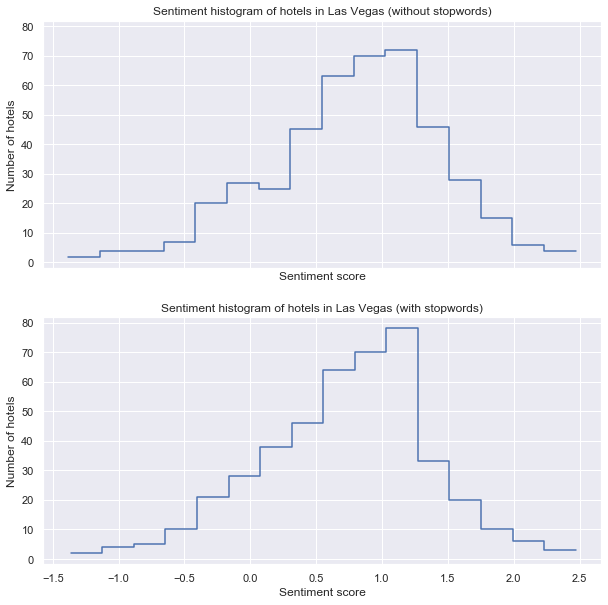

In [20]:
# Create a dictionary containing the avg happiness score of each word from LabMT
afinn_sentiment_score = dict(zip(afinn['word'], afinn['sentiment_score']))

def sentiment_score(reviews, remove_stopwords=True, sentiment_score = afinn_sentiment_score):
    # Create a dictionary for storing sentiment score of each community or business
    sentiment = {}
    
    # Get the set of  stopwords
    stop_words = set(stopwords.words('english'))  
    
    # For each community or business
    for comm in reviews.keys():
        
        # Tokenize the original review only extracting words and set words to lowercase
        words = word_tokenize(re.sub('[^a-zA-Z\s]', ' ', reviews[comm]).lower())
          
        # Remove stopwords
        if remove_stopwords:
            words = [word for word in words if word not in stop_words]
            
        # Create the sentiment list of each word in the word list which also has a sentiment score in LabMT, of each community or business
        sentiments = [sentiment_score[word] for word in words if word in sentiment_score.keys()]
        # Compute the average sentiment score and round it
        avg_sentiment = round(np.mean(sentiments), 3)
        #  Store avg sentiment for each community or business
        sentiment[comm] = avg_sentiment
    
    return sentiment

business_sentiment_without_stopwords = sentiment_score(business_reviews, remove_stopwords = True)
business_sentiment_with_stopwords = sentiment_score(business_reviews, remove_stopwords = False)

# Sort business sentiment by its value for plotting histogram

business_sentiment_without_stopwords_sorted = sorted([v for k, v in business_sentiment_without_stopwords.items()], reverse = True)
business_sentiment_with_stopwords_sorted = sorted([v for k, v in business_sentiment_with_stopwords.items()], reverse = True)


# Plot the histogram of sentiment scores over each hotel
fig, ax = plt.subplots(2,1, figsize=(10, 10), sharex = True, sharey = True)

hist_without_stopwords, bin_edge_without_stopwords = np.histogram(business_sentiment_without_stopwords_sorted, bins = 16)
ax[0].plot(bin_edge_without_stopwords, np.insert(hist_without_stopwords, 0, hist_without_stopwords[0]), drawstyle = 'steps')
ax[0].set_title('Sentiment histogram of hotels in Las Vegas (without stopwords)')
ax[0].set_ylabel('Number of hotels')
ax[0].set_xlabel('Sentiment score')

hist_with_stopwords, bin_edge_with_stopwords = np.histogram(business_sentiment_with_stopwords_sorted, bins = 16)
ax[1].plot(bin_edge_with_stopwords, np.insert(hist_with_stopwords, 0, hist_with_stopwords[0]), drawstyle = 'steps')
ax[1].set_title('Sentiment histogram of hotels in Las Vegas (with stopwords)')
ax[1].set_ylabel('Number of hotels')
ax[1].set_xlabel('Sentiment score')

plt.show()

## The "best" and "worst" Hotels

- **Best 10**

In [23]:
business_sentiment_sorted = sorted([v for k, v in business_sentiment.items()], reverse = True)
i = 1

# Sort the sentiment score dictionary of businesses by value from highest to lowest and pick top 10
for key, value in sorted(business_sentiment_with_stopwords.items(), key = lambda x:x[1], reverse = True)[:10]:
    print('#{} {} - Sentiment: {}, Rating: {}'.format(i, 
                                                      business_df[business_df.business_id == key].name.values[0], 
                                                      value, 
                                                      business_df[business_df.business_id == key].stars.values[0]))
    i += 1

#1 Roberta's Steakhouse - Sentiment: 2.471, Rating: 4.5
#2 Team Kaizen - Sentiment: 2.303, Rating: 5.0
#3 Sands Hotel - Sentiment: 2.25, Rating: 4.5
#4 Fortunes - Sentiment: 2.2, Rating: 3.5
#5 Jennifer Romas' Sexxy - Sentiment: 2.087, Rating: 4.5
#6 Star Motel - Sentiment: 2.067, Rating: 4.5
#7 Lip Smacking Foodie Tours - Sentiment: 2.053, Rating: 5.0
#8 Venetian Casino Grazie Club Gold Room - Sentiment: 2.033, Rating: 4.0
#9 Las Vegas Strip Trips - Sentiment: 2.027, Rating: 5.0
#10 HGVClub - Sentiment: 1.941, Rating: 4.5


- **Worst 10**

In [24]:
i = 1
# Sort the sentiment score dictionary of businesses by value from highest to lowest and pick top 10
for key, value in sorted(business_sentiment_with_stopwords.items(), key = lambda x:x[1], reverse = False)[:10]:
    print('#{} {} - Sentiment: {}, Rating: {}'.format(i,
                                                      business_df[business_df.business_id == key].name.values[0], 
                                                      value, 
                                                      business_df[business_df.business_id == key].stars.values[0]))
    i += 1

#1 Exotic Escapes - Sentiment: -1.364, Rating: 1.0
#2 Umpire - Sentiment: -1.222, Rating: 1.0
#3 Siegel Suites - Sentiment: -1.091, Rating: 2.0
#4 Las Vegas Villa - Sentiment: -0.962, Rating: 2.0
#5 Holiday Motel - Sentiment: -0.926, Rating: 1.5
#6 Desert Star Motel - Sentiment: -0.907, Rating: 1.5
#7 Holiday House Holiday Motel - Sentiment: -0.741, Rating: 2.0
#8 Lamplighter Motel - Sentiment: -0.72, Rating: 1.0
#9 Siegel Suites Bonanza - Sentiment: -0.706, Rating: 1.0
#10 Sahara Westwood Hotel - Sentiment: -0.697, Rating: 1.0


In [25]:
community_sentiment = sentiment_score(community_reviews)
community_sentiment

{0: 0.711, 1: 0.443, 2: 1.004, 3: 1.011}

## Temporal sentiment geomapping

Now that we have identified the general sentiment trends across our Yelp Hotels dataset, it is important to also link these sentiments to the geo-temporal dimension that our dataset comes from. In other words, we know that each hotel is located at a specific (latitude, longitude) location, and that every review has been written at a certain date and hour in time.

We will use these two dimensions to analyze an interactive geo-map, where we position the hotels according to their location on the map, and their sentiment scores in the time domain will dictate the color of their node.

The following two cases are considered:

1. Seasonal temporal map, where we will check if sentiment scores change based on the year quarter (_e.g. Q1 - January to March, etc._) in which they were written;

2. Time-of-day temporal map, where we will check the trend of sentiment scores across the 5 different times of day during which they were written (morning, noon, afternoon, evening, night);

- **Geomap of the overall sentiment score**

This first geomap is showing the overall sentiments across each hotel in Las Vegas. This visualization does not take into account any temporal domain separation, and is included as a baseline reference of how the Las Vegas landscape looks like, in terms of sentiment analysis.

In [9]:
# Convert date object to datetime type
business_review_df.date = pd.to_datetime(business_review_df.date)

# Function for split date into quarters
def quarter(df):
    # Q1
    if (df.month >= 1) & (df.month < 4):
        return 'Q1'
    # Q2
    if (df.month >= 4) & (df.month < 7):
        return 'Q2'
    # Q3
    if (df.month >= 7) & (df.month < 10):
        return 'Q3'
    # Q4
    if (df.month >= 10) & (df.month <= 12):
        return 'Q4'
    
# Function for split date into quarters
def hour(df):
    # Midnight
    if (df.hour >= 0) & (df.hour < 6):
        return 'Night'
    # Morning
    if (df.hour >= 6) & (df.hour < 11):
        return 'Morning'
    # Noon
    if (df.hour >= 11) & (df.hour < 14):
        return 'Noon'   
    # Afternoon
    if (df.hour >= 14) & (df.hour < 18):
        return 'Afternoon'  
    # Night
    if (df.hour >= 18) & (df.hour <= 23):
        return 'Evening'      
    
business_review_df['quarter'] = business_review_df.date.apply(quarter)
business_review_df['day_time'] = business_review_df.date.apply(hour)

def temporal_sentiment(business_review_df, business_df, mode):
    if mode == 'quarter':
        # For each quarter
        for q in business_review_df.quarter.unique():
            #  Filter the business_review_df according to specific quarter
            business_review_quarter_df = business_review_df[business_review_df.quarter == q]
            #  Combine reviews of each business
            business_reviews_quarter = reviews(df = business_review_quarter_df, mode = 'business')
            # Compute the sentiment score dictionary of each business in a quarter
            business_sentiment_quarter = sentiment_score(business_reviews_quarter)
            #  Add sentiment dictionary of each quarter as a column to business_df
            business_df['sentiment_'+q] = business_df['business_id'].map(business_sentiment_quarter)     
            business_df['sentiment_'+q] = business_df['sentiment_'+q].fillna(0)
    
    if mode == 'day_time':
        for time in business_review_df.day_time.unique():
             #  Filter the business_review_df according to specific day time
            business_review_hour_df = business_review_df[business_review_df.day_time == time]
            #  Combine reviews of each business
            business_reviews_hour = reviews(df = business_review_hour_df, mode = 'business')
            # Compute the sentiment score dictionary of each business within a certain day time
            business_sentiment_hour = sentiment_score(business_reviews_hour)
            #  Add sentiment dictionary of each day time as a column to business_df
            business_df['sentiment_'+time] = business_df['business_id'].map(business_sentiment_hour)
            business_df['sentiment_'+time] = business_df['sentiment_'+time].fillna(0)
    
    return  business_df

business_df = temporal_sentiment(business_review_df = business_review_df, business_df = business_df, mode = 'quarter')
business_df = temporal_sentiment(business_review_df = business_review_df, business_df = business_df, mode = 'day_time')

In [11]:
fig = px.scatter_mapbox(business_df, 
                                   lat = 'latitude',
                                   lon = 'longitude',
                                   hover_name = 'name', 
                                   hover_data = ['top_keywords'],
                                   color = 'sentiment', 
                                   color_continuous_scale = 'balance', 
                                   size = 'review_count', 
                                   zoom=10, 
                                   height=300)
fig.update_layout(mapbox_style='carto-positron')

fig.update_layout(margin={'r': 0, 't': 0, 'l': 0, 'b': 0})
fig.show()

As we can see, most hotels have a slighly positive experience rating, with the ones in the center of the city being more inclined to have a better overall score, while the perifery of the city shows some hotels with a rather neutral outlook.

- **Seasonal temporal map (based on yearly quarters)**

For our second geomap, we will compute sentiment scores of businesses in each quarter of year, to see if there is any variation between seasons. Based on the segmentation of time, now it is possible to compute the sentiment score for every hotel during each time-period:

In [12]:
fig_quarter = px.scatter_mapbox(business_df, 
                                    lat = 'latitude',
                                    lon = 'longitude',
                                    hover_name = 'name', 
                                    hover_data = ['top_keywords'],
                                    color =  'sentiment_Q1',
                                    color_continuous_scale = 'balance', 
                                    size = 'review_count', 
                                    zoom = 10, 
                                    height = 300)

fig_quarter.add_trace(px.scatter_mapbox(business_df,
                                              lat = 'latitude',
                                              lon = 'longitude',
                                              hover_name = 'name', 
                                              hover_data = ['top_keywords'],
                                              color =  'sentiment_Q2',
                                              color_continuous_scale = 'balance', 
                                              size = 'review_count', 
                                              zoom = 10, 
                                              height = 300).data[0])
fig_quarter.add_trace(px.scatter_mapbox(business_df,
                                              lat = 'latitude',
                                              lon = 'longitude',
                                              hover_name = 'name', 
                                              hover_data = ['top_keywords'],
                                              color =  'sentiment_Q3',
                                              color_continuous_scale = 'balance', 
                                              size = 'review_count', 
                                              zoom = 10, 
                                              height = 300).data[0])
fig_quarter.add_trace(px.scatter_mapbox(business_df,
                                              lat = 'latitude',
                                              lon = 'longitude',
                                              hover_name = 'name', 
                                              hover_data = ['top_keywords'],
                                              color =  'sentiment_Q4',
                                              color_continuous_scale = 'balance', 
                                              size = 'review_count', 
                                              zoom = 10, 
                                              height = 300).data[0])

updatemenus = [dict(type = "buttons", 
                             direction = "down",
                             buttons = 
                             list([dict(args=[{'visible': [True, False, False, False]}, 'type'],
                                         label = "Q1", 
                                         method="update"),

                                   dict(args=[{'visible': [False, True, False, False]}, 'type'],
                                         label = "Q2", 
                                         method="update"),
                                   
                                   dict(args=[{'visible': [False, False, True, False]}, 'type'],
                                         label = "Q3", 
                                         method="update"),
                                   
                                   dict(args=[{'visible': [False, False, False, True]}, 'type'],
                                         label = "Q4", 
                                         method="update")
                                  ])
                       )]


fig_quarter.update_layout(updatemenus = updatemenus,
                         legend_title_text='Sentiment score over year quarters')
fig_quarter.update_layout(mapbox_style='carto-positron')
fig_quarter.update_layout(margin={'r': 0, 't': 0, 'l': 0, 'b': 0})
fig_quarter.show()

Based on the interactive ___`plotly`___ visualization above, we can identify that most positive sentiment scores are given in Q1 of the year, meaning in the months between January & March (inclusive), while the lowest sentiment scores can be found from reviews written in the Q3 period of the year (meaning in the months of July, August & September).

It seems that this behavior is in connection with the both the higher tourist expectations, who generally arrive in the summer months, as well as the increased crime rate during the summertime (statistics found from US journalism house: [report here](https://www.governing.com/topics/public-justice-safety/gov-summer-crime-rates-increases-police.html)). 

- **Time-of-day temporal map**

Our final geomap refers to the sentiment scores received by reviews, grouped by the time of day during which they were written. We are interested in seeing if there is any change between the different periods of a day during which a review is submitted. For that, we will again compute sentiment scores of businesses for each time of day individually, and use an interactive ___`plotly`___ visualization to show the differences in scores as changing node colors.

In [14]:
fig_day = px.scatter_mapbox(business_df, 
                                    lat = 'latitude',
                                    lon = 'longitude',
                                    hover_name = 'name', 
                                    hover_data = ['top_keywords'],
                                    color =  'sentiment_Morning',
                                    color_continuous_scale = 'balance', 
                                    size = 'review_count', 
                                    zoom = 10, 
                                    height = 300)

fig_day.add_trace(px.scatter_mapbox(business_df,
                                              lat = 'latitude',
                                              lon = 'longitude',
                                              hover_name = 'name', 
                                              hover_data = ['top_keywords'],
                                              color =  'sentiment_Noon',
                                              color_continuous_scale = 'balance', 
                                              size = 'review_count', 
                                              zoom = 10, 
                                              height = 300).data[0])
fig_day.add_trace(px.scatter_mapbox(business_df,
                                              lat = 'latitude',
                                              lon = 'longitude',
                                              hover_name = 'name', 
                                              hover_data = ['top_keywords'],
                                              color =  'sentiment_Afternoon',
                                              color_continuous_scale = 'balance', 
                                              size = 'review_count', 
                                              zoom = 10, 
                                              height = 300).data[0])
fig_day.add_trace(px.scatter_mapbox(business_df,
                                              lat = 'latitude',
                                              lon = 'longitude',
                                              hover_name = 'name', 
                                              hover_data = ['top_keywords'],
                                              color =  'sentiment_Night',
                                              color_continuous_scale = 'balance', 
                                              size = 'review_count', 
                                              zoom = 10, 
                                              height = 300).data[0])
fig_day.add_trace(px.scatter_mapbox(business_df,
                                              lat = 'latitude',
                                              lon = 'longitude',
                                              hover_name = 'name', 
                                              hover_data = ['top_keywords'],
                                              color =  'sentiment_Evening',
                                              color_continuous_scale = 'balance', 
                                              size = 'review_count', 
                                              zoom = 10, 
                                              height = 300).data[0])

updatemenus = [dict(type = "buttons", 
                             direction = "down",
                             buttons = 
                             list([dict(args=[{'visible': [True, False, False, False, False]}, 'type'],
                                         label = "Morning", 
                                         method="update"),

                                   dict(args=[{'visible': [False, True, False, False, False]}, 'type'],
                                         label = "Noon", 
                                         method="update"),
                                   
                                   dict(args=[{'visible': [False, False, True, False, False]}, 'type'],
                                         label = "Afternoon", 
                                         method="update"),
                                   
                                   dict(args=[{'visible': [False, False, False, True, False]}, 'type'],
                                         label = "Evening", 
                                         method="update"),
                                   
                                   dict(args=[{'visible': [False, False, False, False, True]}, 'type'],
                                         label = "Night", 
                                         method="update")
                                  ])
                       )]


fig_day.update_layout(updatemenus = updatemenus,
                         legend_title_text='')
fig_day.update_layout(mapbox_style='carto-positron')
fig_day.update_layout(margin={'r': 0, 't': 0, 'l': 0, 'b': 0})
fig_day.show()

Through understanding the geomap above, we can clearly see that the least-positive reviews are written during the morning time (between 06:00 AM and 11:00 AM), with almost no hotel at all received an aggregated sentiment score above 1 (out of max. +5). In contrast, reviews written during the evening are the most positive, with aggregated sentiments for the same hotel crossing above the 1.00 score mark, and, for the best hotels, averaging around 1.7-1.8 in total. Reviews posted during the afternoon or nighttime seem to be more neutral than during the evening, however still manage to cross the borderline 0.00 score.

In general, this clearly shows a trend in the review-posting behavior of users, and by clicking the buttons of the visualization, one can get a quick overview that this trend is applicable across the vast majority of the hotels, making it a temporal trend effect (rather than localized behaviour of a specific hotel).